In [8]:
pip install torch torchvision tqdm

In [9]:
# mae_compare.py
# Minimal, Colab-friendly MAE training on STL-10 with automatic download.
# Trains Original MAE vs Improved MAE (curriculum masking + frequency + uniformity),
# evaluates both (linear probe + fine-tune), prints comparison, and supports checkpoint resume.
%%writefile mae_compare2.py
from __future__ import annotations

import argparse
import json
import math
import os
import random
import signal
import time
from contextlib import nullcontext
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm


# --------------------------
# Utils
# --------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def accuracy(output: torch.Tensor, target: torch.Tensor, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        B = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        out = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0)
            out.append((correct_k * (100.0 / B)).item())
        return out


def ensure_dir(p: str | Path):
    Path(p).mkdir(parents=True, exist_ok=True)


# --------------------------
# Dataset builders (STL-10)
# --------------------------

def build_stl10_pretrain(root: str, img_size: int) -> tv.datasets.STL10:
    t = transforms.Compose(
        [
            transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),  # in [0,1]
        ]
    )
    ds = tv.datasets.STL10(
        root=root, split="unlabeled", download=True, transform=t
    )
    return ds


def build_stl10_classification(
    root: str, img_size: int
) -> Tuple[tv.datasets.STL10, tv.datasets.STL10]:
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    t_train = transforms.Compose(
        [
            transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    t_eval = transforms.Compose(
        [
            transforms.Resize(int(img_size * 1.14)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    train = tv.datasets.STL10(
        root=root, split="train", download=True, transform=t_train
    )
    test = tv.datasets.STL10(
        root=root, split="test", download=True, transform=t_eval
    )
    return train, test


# --------------------------
# MAE model: ViT encoder + lightweight decoder (minimal)
# --------------------------

def get_2d_sincos_pos_embed(embed_dim: int, h: int, w: int) -> torch.Tensor:
    """
    Build 2D sine-cosine positional embeddings with total dimension `embed_dim`.
    Half dims for height, half for width.
    """
    assert embed_dim % 2 == 0, "embed_dim must be even"

    def get_1d_sin_cos(pos_1d: torch.Tensor, dim: int) -> torch.Tensor:
        pos_1d = pos_1d.view(-1)
        assert dim % 2 == 0
        half = dim // 2
        omega = torch.arange(half, dtype=torch.float32)
        omega = 1.0 / (10000 ** (omega / half))
        out = pos_1d[:, None] * omega[None, :]  # (L, half)
        return torch.cat([torch.sin(out), torch.cos(out)], dim=1)  # (L, dim)

    grid_h = torch.arange(h, dtype=torch.float32)
    grid_w = torch.arange(w, dtype=torch.float32)
    axis_dim = embed_dim // 2
    emb_h = get_1d_sin_cos(grid_h, axis_dim)  # (h, axis_dim)
    emb_w = get_1d_sin_cos(grid_w, axis_dim)  # (w, axis_dim)

    emb_h_2d = emb_h.unsqueeze(1).expand(h, w, -1)  # (h, w, axis_dim)
    emb_w_2d = emb_w.unsqueeze(0).expand(h, w, -1)  # (h, w, axis_dim)
    emb_2d = torch.cat([emb_h_2d, emb_w_2d], dim=-1)  # (h, w, embed_dim)
    return emb_2d.view(h * w, embed_dim)


class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hidden = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=6, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)  # B, N, 3C
        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # 3, B, heads, N, head_dim
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale  # B, heads, N, N
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio=mlp_ratio)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(
            in_ch, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)  # B, C, H/ps, W/ps
        x = x.flatten(2).transpose(1, 2)  # B, L, C
        return x


class MAE(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_ch=3,
        embed_dim=192,
        depth=8,
        num_heads=6,
        decoder_embed_dim=128,
        decoder_depth=4,
        decoder_num_heads=4,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_ch, embed_dim)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid = img_size // patch_size
        self.num_patches = self.grid * self.grid
        self.norm_pix_loss = norm_pix_loss

        pos = get_2d_sincos_pos_embed(embed_dim, self.grid, self.grid)  # L x C
        self.register_buffer("pos_embed_enc", pos.unsqueeze(0), persistent=False)

        self.encoder = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)]
        )
        self.enc_norm = nn.LayerNorm(embed_dim)

        self.dec_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        pos_dec = get_2d_sincos_pos_embed(decoder_embed_dim, self.grid, self.grid)
        self.register_buffer("pos_embed_dec", pos_dec.unsqueeze(0), persistent=False)
        self.decoder = nn.ModuleList(
            [
                TransformerBlock(decoder_embed_dim, decoder_num_heads, mlp_ratio)
                for _ in range(decoder_depth)
            ]
        )
        self.dec_norm = nn.LayerNorm(decoder_embed_dim)
        self.head = nn.Linear(
            decoder_embed_dim, patch_size * patch_size * in_ch
        )

        nn.init.trunc_normal_(self.mask_token, std=0.02)

    def patchify(self, imgs: torch.Tensor) -> torch.Tensor:
        p = self.patch_size
        h = w = self.img_size // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum("nchpwq->nhwpqc", x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p * p * 3))
        return x

    def unpatchify(self, x: torch.Tensor) -> torch.Tensor:
        p = self.patch_size
        h = w = self.img_size // p
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum("nhwpqc->nchpwq", x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, w * p))
        return imgs

    def random_masking(
        self, x: torch.Tensor, mask_ratio: float
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        B, L, C = x.shape
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(B, L, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(
            x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, C)
        )
        mask = torch.ones(B, L, device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        return x_masked, mask, ids_restore

    def forward_encoder(self, imgs: torch.Tensor, mask_ratio: float):
        x = self.patch_embed(imgs)  # B, L, C
        x = x + self.pos_embed_enc
        x_vis, mask, ids_restore = self.random_masking(x, mask_ratio)
        for blk in self.encoder:
            x_vis = blk(x_vis)
        x_vis = self.enc_norm(x_vis)
        return x_vis, mask, ids_restore

    def forward_decoder(self, x_vis: torch.Tensor, ids_restore: torch.Tensor):
        x = self.dec_embed(x_vis)
        B, L_vis, C = x.shape
        L = self.num_patches
        mask_tokens = self.mask_token.expand(B, L - L_vis, -1)
        x_ = torch.cat([x, mask_tokens], dim=1)
        x_ = torch.gather(
            x_, dim=1, index=ids_restore.unsqueeze(-1).expand(-1, -1, C)
        )
        x_ = x_ + self.pos_embed_dec
        for blk in self.decoder:
            x_ = blk(x_)
        x_ = self.dec_norm(x_)
        x_ = self.head(x_)
        return x_

    def forward_loss(
        self, imgs: torch.Tensor, pred: torch.Tensor, mask: torch.Tensor
    ):
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True) + 1e-6
            target = (target - mean) / var.sqrt()
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # B, L
        loss = (loss * mask).sum() / (mask.sum() + 1e-5)
        return loss

    def forward_mae(self, imgs: torch.Tensor, mask_ratio: float):
        z, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(z, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask, z

    def forward_encoder_full(self, imgs: torch.Tensor):
        x = self.patch_embed(imgs)
        x = x + self.pos_embed_enc
        for blk in self.encoder:
            x = blk(x)
        x = self.enc_norm(x)  # B, L, C
        feat = x.mean(dim=1)
        return feat


# --------------------------
# Improved losses
# --------------------------

def laplacian_loss_masked(
    pred_img: torch.Tensor, tgt_img: torch.Tensor, mask_img: torch.Tensor
) -> torch.Tensor:
    """
    Depthwise Laplacian high-frequency L1 loss over masked pixels.
    pred_img, tgt_img: BxCxHxW in [0,1]
    mask_img: Bx1xHxW in {0,1}
    """
    B, C, H, W = pred_img.shape
    base = torch.tensor(
        [[0.0, 1.0, 0.0], [1.0, -4.0, 1.0], [0.0, 1.0, 0.0]],
        dtype=pred_img.dtype,
        device=pred_img.device,
    ).view(1, 1, 3, 3)
    # depthwise conv kernel: C x 1 x 3 x 3
    k = base.repeat(C, 1, 1, 1)
    Lp = F.conv2d(pred_img, k, padding=1, groups=C)
    Lt = F.conv2d(tgt_img, k, padding=1, groups=C)
    diff = (Lp - Lt).abs()
    diff = diff * mask_img  # broadcast across channels
    denom = mask_img.sum() * C + 1e-6
    return diff.sum() / denom


def uniformity_loss(z_tokens: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    z = F.normalize(z_tokens.mean(dim=1), dim=1)  # B x C
    sim = z @ z.t()
    dist2 = 2.0 * (1.0 - sim).clamp(min=0.0)
    B = z.shape[0]
    if B <= 1:
        return torch.tensor(0.0, device=z_tokens.device, dtype=z_tokens.dtype)
    mask = ~torch.eye(B, dtype=torch.bool, device=z_tokens.device)
    vals = torch.exp(-2.0 * dist2[mask])
    return torch.log(vals.mean() + eps)


def expand_patch_mask_to_image(
    mask: torch.Tensor, img_size: int, patch_size: int
) -> torch.Tensor:
    grid = img_size // patch_size
    mask_img = mask.view(mask.size(0), 1, grid, grid)
    mask_img = F.interpolate(mask_img, scale_factor=patch_size, mode="nearest")
    return mask_img


# --------------------------
# Training loops + checkpointing
# --------------------------

@dataclass
class PretrainConfig:
    epochs: int = 10
    batch_size: int = 64
    lr: float = 1.5e-4
    weight_decay: float = 0.05
    warmup_epochs: int = 2
    img_size: int = 224
    patch_size: int = 16
    mask_ratio: float = 0.75
    mask_ratio_start: float = 0.5
    mask_ratio_sched: str = "const"  # "const" | "linear" | "cosine"
    mask_ratio_warmup_epochs: int = 4
    norm_pix_loss: bool = True
    loss_freq_w: float = 0.0
    loss_unif_w: float = 0.0
    amp: bool = True
    device: str = "cuda"
    # checkpoint
    ckpt_dir: str = "./runs/original"
    save_every: int = 2
    resume: bool = False


@dataclass
class ClassifyConfig:
    epochs_lp: int = 10
    epochs_ft: int = 10
    batch_size: int = 128
    lr_lp: float = 0.1
    lr_ft: float = 5e-4
    weight_decay_ft: float = 0.05
    img_size: int = 224
    device: str = "cuda"


def cosine_lr(step, total_steps, base_lr, min_lr=0.0, warmup_steps=0):
    if step < warmup_steps:
        return base_lr * step / max(1, warmup_steps)
    q = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return min_lr + 0.5 * (base_lr - min_lr) * (1 + math.cos(math.pi * q))


def schedule_mask_ratio(epoch: int, step: int, iters: int, cfg: PretrainConfig):
    if cfg.mask_ratio_sched == "const":
        return cfg.mask_ratio
    progress = (epoch * iters + step) / max(1, cfg.mask_ratio_warmup_epochs * iters)
    progress = max(0.0, min(1.0, progress))
    if cfg.mask_ratio_sched == "linear":
        return cfg.mask_ratio_start + (cfg.mask_ratio - cfg.mask_ratio_start) * progress
    if cfg.mask_ratio_sched == "cosine":
        cos_t = (1.0 - math.cos(math.pi * progress)) / 2.0
        return cfg.mask_ratio_start + (cfg.mask_ratio - cfg.mask_ratio_start) * cos_t
    return cfg.mask_ratio


def save_ckpt(path: str, model: nn.Module, opt, scaler, epoch: int, meta: dict):
    ensure_dir(Path(path).parent)
    torch.save(
        {
            "model": model.state_dict(),
            "optimizer": opt.state_dict(),
            "scaler": scaler.state_dict() if scaler is not None else None,
            "epoch": epoch,
            "meta": meta,
        },
        path,
    )


def load_ckpt(path: str, model: nn.Module, opt, scaler):
    chk = torch.load(path, map_location="cpu")
    model.load_state_dict(chk["model"])
    if opt is not None and "optimizer" in chk and chk["optimizer"] is not None:
        opt.load_state_dict(chk["optimizer"])
    if scaler is not None and "scaler" in chk and chk["scaler"] is not None:
        scaler.load_state_dict(chk["scaler"])
    return chk.get("epoch", -1), chk.get("meta", {})


def pretrain_mae(
    model: MAE,
    loader: DataLoader,
    cfg: PretrainConfig,
    improved: bool = False,
) -> Dict[str, float]:
    device = cfg.device
    amp_enabled = cfg.amp and torch.cuda.is_available() and device.startswith("cuda")
    autocast_ctx = (
        torch.amp.autocast(device_type="cuda", dtype=torch.float16, enabled=amp_enabled)
        if amp_enabled
        else nullcontext()
    )
    scaler = torch.amp.GradScaler("cuda") if amp_enabled else None

    model.train()
    opt = torch.optim.AdamW(
        model.parameters(), lr=cfg.lr, betas=(0.9, 0.95), weight_decay=cfg.weight_decay
    )

    # resume support
    start_epoch = 0
    last_ckpt = Path(cfg.ckpt_dir) / "checkpoint_last.pt"
    if cfg.resume and last_ckpt.exists():
        print(f"[pretrain] Resuming from {last_ckpt}")
        e, meta = load_ckpt(str(last_ckpt), model, opt, scaler)
        start_epoch = int(e) + 1

    total_steps = cfg.epochs * len(loader)
    step_idx = start_epoch * len(loader)
    t0 = time.time()

    # Save checkpoint on SIGINT
    interrupted = {"flag": False}

    def handle_sigint(signum, frame):
        interrupted["flag"] = True
        print("\n[pretrain] Caught interrupt. Saving checkpoint...")

    signal.signal(signal.SIGINT, handle_sigint)

    for epoch in range(start_epoch, cfg.epochs):
        pbar = tqdm(
            loader,
            desc=f"Pretrain {'Improved' if improved else 'Original'} E{epoch+1}/{cfg.epochs}",
        )
        for it, (imgs, _) in enumerate(pbar):
            imgs = imgs.to(device, non_blocking=True)

            mask_ratio = (
                schedule_mask_ratio(epoch, it, len(loader), cfg)
                if improved
                else cfg.mask_ratio
            )
            lr = cosine_lr(
                step_idx,
                total_steps,
                cfg.lr,
                min_lr=0.0,
                warmup_steps=cfg.warmup_epochs * len(loader),
            )
            for pg in opt.param_groups:
                pg["lr"] = lr

            opt.zero_grad(set_to_none=True)
            with autocast_ctx:
                loss_mae, pred, mask, z = model.forward_mae(imgs, mask_ratio)
                loss = loss_mae
                if improved and cfg.loss_freq_w > 0.0:
                    pred_img = model.unpatchify(pred)
                    mask_img = expand_patch_mask_to_image(
                        mask, model.img_size, model.patch_size
                    )
                    loss_freq = laplacian_loss_masked(
                        pred_img.clamp(0, 1), imgs, mask_img
                    )
                    loss = loss + cfg.loss_freq_w * loss_freq
                if improved and cfg.loss_unif_w > 0.0:
                    loss_unif = uniformity_loss(z)
                    loss = loss + cfg.loss_unif_w * loss_unif

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

            pbar.set_postfix(
                {"lr": f"{lr:.2e}", "mask": f"{mask_ratio:.2f}", "loss": f"{loss.item():.4f}"}
            )
            step_idx += 1

        # save periodic checkpoints
        if (epoch + 1) % max(1, cfg.save_every) == 0:
            meta = {
                "improved": improved,
                "epoch": epoch,
                "cfg": cfg.__dict__,
            }
            save_ckpt(str(last_ckpt), model, opt, scaler, epoch, meta)

        if interrupted["flag"]:
            meta = {
                "improved": improved,
                "epoch": epoch,
                "cfg": cfg.__dict__,
            }
            save_ckpt(str(last_ckpt), model, opt, scaler, epoch, meta)
            print("[pretrain] Checkpoint saved after interrupt.")
            raise KeyboardInterrupt

    # final save
    meta = {"improved": improved, "epoch": cfg.epochs - 1, "cfg": cfg.__dict__}
    save_ckpt(str(last_ckpt), model, opt, scaler, cfg.epochs - 1, meta)

    t1 = time.time()
    return {"pretrain_time_sec": t1 - t0, "start_epoch": start_epoch, "end_epoch": cfg.epochs - 1}


class LinearHead(nn.Module):
    def __init__(self, in_dim: int, num_classes: int):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_dim, affine=False)
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        x = self.bn(x)
        return self.fc(x)


def train_linear_probe(
    model: MAE, train_loader, test_loader, cfg: ClassifyConfig
) -> float:
    device = cfg.device
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

    head = LinearHead(
        in_dim=model.enc_norm.normalized_shape[0], num_classes=10
    ).to(device)

    opt = torch.optim.SGD(
        head.parameters(), lr=cfg.lr_lp, momentum=0.9, weight_decay=0.0
    )
    amp_enabled = torch.cuda.is_available() and device.startswith("cuda")
    autocast_ctx = (
        torch.amp.autocast(device_type="cuda", dtype=torch.float16, enabled=amp_enabled)
        if amp_enabled
        else nullcontext()
    )
    scaler = torch.amp.GradScaler("cuda") if amp_enabled else None

    for epoch in range(cfg.epochs_lp):
        head.train()
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                feats = model.forward_encoder_full(imgs)
            if scaler is not None:
                with autocast_ctx:
                    logits = head(feats)
                    loss = F.cross_entropy(logits, labels)
                opt.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                logits = head(feats)
                loss = F.cross_entropy(logits, labels)
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()

    head.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            feats = model.forward_encoder_full(imgs)
            logits = head(feats)
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.numel()
    return 100.0 * correct / max(1, total)


def finetune(model: MAE, train_loader, test_loader, cfg: ClassifyConfig) -> float:
    device = cfg.device
    head = nn.Linear(model.enc_norm.normalized_shape[0], 10).to(device)
    params = list(model.parameters()) + list(head.parameters())
    opt = torch.optim.AdamW(params, lr=cfg.lr_ft, weight_decay=cfg.weight_decay_ft)

    amp_enabled = torch.cuda.is_available() and device.startswith("cuda")
    autocast_ctx = (
        torch.amp.autocast(device_type="cuda", dtype=torch.float16, enabled=amp_enabled)
        if amp_enabled
        else nullcontext()
    )
    scaler = torch.amp.GradScaler("cuda") if amp_enabled else None

    model.train()
    head.train()
    for epoch in range(cfg.epochs_ft):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            if scaler is not None:
                with autocast_ctx:
                    feats = model.forward_encoder_full(imgs)
                    logits = head(feats)
                    loss = F.cross_entropy(logits, labels)
                opt.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                feats = model.forward_encoder_full(imgs)
                logits = head(feats)
                loss = F.cross_entropy(logits, labels)
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()

    model.eval()
    head.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            feats = model.forward_encoder_full(imgs)
            logits = head(feats)
            pred = logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.numel()
    return 100.0 * correct / max(1, total)


# --------------------------
# Orchestration
# --------------------------

def run_one_variant(
    variant_name: str,
    data_root: str,
    img_size: int,
    pre_cfg: PretrainConfig,
    clf_cfg: ClassifyConfig,
    improved: bool,
    device: str,
    out_dir: str,
) -> Dict[str, float]:
    ensure_dir(out_dir)
    # Data
    ds_pre = build_stl10_pretrain(data_root, img_size)
    ds_tr, ds_te = build_stl10_classification(data_root, img_size)
    dl_pre = DataLoader(
        ds_pre, batch_size=pre_cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    dl_tr = DataLoader(
        ds_tr, batch_size=clf_cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    dl_te = DataLoader(
        ds_te, batch_size=clf_cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    # Model
    model = MAE(
        img_size=img_size,
        patch_size=pre_cfg.patch_size,
        embed_dim=192,
        depth=8,
        num_heads=6,
        decoder_embed_dim=128,
        decoder_depth=4,
        decoder_num_heads=4,
        norm_pix_loss=pre_cfg.norm_pix_loss,
    ).to(device)

    # Pretrain with checkpoint dir
    pre_cfg.ckpt_dir = out_dir
    times = pretrain_mae(model, dl_pre, pre_cfg, improved=improved)

    # Save a snapshot of the encoder after pretraining for reproducibility
    torch.save(model.state_dict(), str(Path(out_dir) / "encoder_pretrained.pt"))

    # Linear probe
    lp_acc = train_linear_probe(model, dl_tr, dl_te, clf_cfg)

    # Fine-tune
    ft_acc = finetune(model, dl_tr, dl_te, clf_cfg)

    # Save results JSON
    result = {
        "variant": variant_name,
        "lp_top1": lp_acc,
        "ft_top1": ft_acc,
        **times,
    }
    with open(Path(out_dir) / "results.json", "w") as f:
        json.dump(result, f, indent=2)

    return result


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_root", type=str, default="./data")
    parser.add_argument("--img_size", type=int, default=224)
    parser.add_argument("--epochs_pretrain", type=int, default=10)
    parser.add_argument("--epochs_lp", type=int, default=10)
    parser.add_argument("--epochs_ft", type=int, default=10)
    parser.add_argument("--batch_pretrain", type=int, default=64)
    parser.add_argument("--batch_cls", type=int, default=128)
    parser.add_argument("--device", type=str, default="cuda")
    parser.add_argument("--output_root", type=str, default="./runs")
    parser.add_argument("--resume_pretrain", action="store_true")
    parser.add_argument("--save_every", type=int, default=2)
    args = parser.parse_args()

    set_seed(42)
    device = args.device if torch.cuda.is_available() else "cpu"
    ensure_dir(args.output_root)

    # Original MAE config
    pre_orig = PretrainConfig(
        epochs=args.epochs_pretrain,
        batch_size=args.batch_pretrain,
        lr=1.5e-4,
        weight_decay=0.05,
        warmup_epochs=2,
        img_size=args.img_size,
        patch_size=16,
        mask_ratio=0.75,
        mask_ratio_start=0.5,
        mask_ratio_sched="const",
        mask_ratio_warmup_epochs=0,
        norm_pix_loss=True,
        loss_freq_w=0.0,
        loss_unif_w=0.0,
        amp=True,
        device=device,
        ckpt_dir=str(Path(args.output_root) / "original"),
        save_every=args.save_every,
        resume=args.resume_pretrain,
    )
    clf = ClassifyConfig(
        epochs_lp=args.epochs_lp,
        epochs_ft=args.epochs_ft,
        batch_size=args.batch_cls,
        lr_lp=0.1,
        lr_ft=5e-4,
        weight_decay_ft=0.05,
        img_size=args.img_size,
        device=device,
    )

    # Improved MAE config
    pre_plus = PretrainConfig(
        epochs=args.epochs_pretrain,
        batch_size=args.batch_pretrain,
        lr=1.5e-4,
        weight_decay=0.05,
        warmup_epochs=2,
        img_size=args.img_size,
        patch_size=16,
        mask_ratio=0.75,
        mask_ratio_start=0.5,
        mask_ratio_sched="linear",  # curriculum
        mask_ratio_warmup_epochs=max(2, args.epochs_pretrain // 2),
        norm_pix_loss=True,
        loss_freq_w=0.05,  # frequency loss weight
        loss_unif_w=0.01,  # uniformity loss weight
        amp=True,
        device=device,
        ckpt_dir=str(Path(args.output_root) / "improved"),
        save_every=args.save_every,
        resume=args.resume_pretrain,
    )

    print("Running Original MAE...")
    res_orig = run_one_variant(
        "original",
        args.data_root,
        args.img_size,
        pre_orig,
        clf,
        improved=False,
        device=device,
        out_dir=str(Path(args.output_root) / "original"),
    )
    print("Running Improved MAE...")
    res_plus = run_one_variant(
        "improved",
        args.data_root,
        args.img_size,
        pre_plus,
        clf,
        improved=True,
        device=device,
        out_dir=str(Path(args.output_root) / "improved"),
    )

    # Compare
    def fmt(r):
        return f"{r['variant']:>9s} | LP@1: {r['lp_top1']:.2f}% | FT@1: {r['ft_top1']:.2f}% | pretrain_time: {int(r['pretrain_time_sec'])}s"

    print("\nComparison on STL-10 (small schedule)")
    print("-------------------------------------")
    print(fmt(res_orig))
    print(fmt(res_plus))
    print("\nOutputs:")
    print(f"- Original artifacts: {Path(args.output_root) / 'original'}")
    print(f"- Improved artifacts: {Path(args.output_root) / 'improved'}")
    print("- Each folder contains checkpoints (checkpoint_last.pt), pretrained encoder, and results.json.")
    print("- Use --resume_pretrain to continue from an interrupted run.")


if __name__ == "__main__":
    main()

Writing mae_compare2.py


In [10]:
!python mae_compare2.py \
  --epochs_pretrain 10 --epochs_lp 10 --epochs_ft 10 \
  --batch_pretrain 64 --batch_cls 128 \
  --img_size 224 \
  --output_root ./runs \
  --resume_pretrain

Running Original MAE...
Pretrain Original E1/10: 100% 1563/1563 [03:53<00:00,  6.68it/s, lr=7.50e-05, mask=0.75, loss=0.7210]
Pretrain Original E2/10: 100% 1563/1563 [03:48<00:00,  6.84it/s, lr=1.50e-04, mask=0.75, loss=0.6457]
Pretrain Original E3/10: 100% 1563/1563 [03:51<00:00,  6.76it/s, lr=1.44e-04, mask=0.75, loss=0.5729]
Pretrain Original E4/10: 100% 1563/1563 [03:51<00:00,  6.75it/s, lr=1.28e-04, mask=0.75, loss=0.5426]
Pretrain Original E5/10: 100% 1563/1563 [03:46<00:00,  6.89it/s, lr=1.04e-04, mask=0.75, loss=0.5058]
Pretrain Original E6/10: 100% 1563/1563 [03:45<00:00,  6.93it/s, lr=7.50e-05, mask=0.75, loss=0.4198]
Pretrain Original E7/10: 100% 1563/1563 [03:46<00:00,  6.90it/s, lr=4.63e-05, mask=0.75, loss=0.4575]
Pretrain Original E8/10: 100% 1563/1563 [03:46<00:00,  6.91it/s, lr=2.20e-05, mask=0.75, loss=0.4555]
Pretrain Original E9/10: 100% 1563/1563 [03:48<00:00,  6.84it/s, lr=5.72e-06, mask=0.75, loss=0.4782]
Pretrain Original E10/10: 100% 1563/1563 [03:50<00:00,  6.

Saved comparison grid to: runs/compare/recon_grid.png


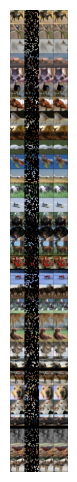

In [11]:
# Visualize side-by-side reconstructions for Original vs Improved MAE
# Uses the models saved by mae_compare.py under ./runs/original and ./runs/improved

import torch
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Import model and helpers from the training script
from mae_compare import MAE, expand_patch_mask_to_image

device = "cuda" if torch.cuda.is_available() else "cpu"
data_root = "./data"
out_dir = Path("./runs/compare")
out_dir.mkdir(parents=True, exist_ok=True)

# Must match the architecture used in mae_compare.py
img_size = 224
patch_size = 16
embed_dim = 192
depth = 8
num_heads = 6
decoder_embed_dim = 128
decoder_depth = 4
decoder_num_heads = 4
norm_pix_loss = True  # we trained with normalized patch targets

# Instantiate two models (same arch)
m_orig = MAE(
    img_size=img_size,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    decoder_embed_dim=decoder_embed_dim,
    decoder_depth=decoder_depth,
    decoder_num_heads=decoder_num_heads,
    norm_pix_loss=norm_pix_loss,
).to(device).eval()

m_impr = MAE(
    img_size=img_size,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    decoder_embed_dim=decoder_embed_dim,
    decoder_depth=decoder_depth,
    decoder_num_heads=decoder_num_heads,
    norm_pix_loss=norm_pix_loss,
).to(device).eval()

def load_state(model, dirpath: str):
    p1 = Path(dirpath) / "encoder_pretrained.pt"
    p2 = Path(dirpath) / "checkpoint_last.pt"
    if p1.exists():
        sd = torch.load(p1, map_location="cpu")
        model.load_state_dict(sd)
        return True
    if p2.exists():
        chk = torch.load(p2, map_location="cpu")
        model.load_state_dict(chk["model"])
        return True
    return False

assert load_state(m_orig, "./runs/original"), "Could not load original model weights"
assert load_state(m_impr, "./runs/improved"), "Could not load improved model weights"

# Dataset for visualization (no normalization)
vis_transform = transforms.Compose([
    transforms.Resize(int(img_size * 1.14)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),  # [0,1]
])
ds_vis = tv.datasets.STL10(root=data_root, split="test", download=True, transform=vis_transform)
dl = torch.utils.data.DataLoader(ds_vis, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

def compute_mask_indices(B, L, mask_ratio, device, seed=1234):
    # Deterministic mask for both models
    gen = torch.Generator(device=device)
    gen.manual_seed(seed)
    noise = torch.rand(B, L, device=device, generator=gen)
    ids_shuffle = torch.argsort(noise, dim=1)
    len_keep = int(L * (1 - mask_ratio))
    ids_keep = ids_shuffle[:, :len_keep]
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    mask = torch.ones(B, L, device=device)
    mask[:, :len_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)
    return ids_keep, ids_restore, mask

@torch.no_grad()
def encode_with_custom_mask(model: MAE, imgs: torch.Tensor, ids_keep: torch.Tensor):
    # Build tokens then keep only visible patch indices
    x = model.patch_embed(imgs) + model.pos_embed_enc  # B,L,C
    B, L, C = x.shape
    x_vis = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, C))
    for blk in model.encoder:
        x_vis = blk(x_vis)
    x_vis = model.enc_norm(x_vis)
    return x_vis

@torch.no_grad()
def denorm_pred_with_target_stats(model: MAE, pred: torch.Tensor, imgs: torch.Tensor):
    # pred: B x L x (p*p*3), imgs: B x 3 x H x W in [0,1]
    target = model.patchify(imgs)  # B x L x (p*p*3)
    mean = target.mean(dim=-1, keepdim=True)
    std = torch.sqrt(target.var(dim=-1, keepdim=True) + 1e-6)
    pred_denorm = pred * std + mean
    return model.unpatchify(pred_denorm).clamp(0, 1)

tiles = []
mask_ratio = 0.75
num_batches = 2  # 2*16 = 32 images; increase for more

for bidx, (imgs, _) in enumerate(dl):
    if bidx >= num_batches:
        break
    imgs = imgs.to(device)

    # Compute deterministic mask once for both models
    B = imgs.size(0)
    L = (img_size // patch_size) ** 2
    ids_keep, ids_restore, mask = compute_mask_indices(B, L, mask_ratio, device)

    # Encode with same mask for both
    z_o = encode_with_custom_mask(m_orig, imgs, ids_keep)
    z_p = encode_with_custom_mask(m_impr, imgs, ids_keep)

    # Decode for both using same ids_restore
    pred_o = m_orig.forward_decoder(z_o, ids_restore)
    pred_p = m_impr.forward_decoder(z_p, ids_restore)

    # De-normalize predicted patches back to pixel space (since norm_pix_loss=True)
    rec_o = denorm_pred_with_target_stats(m_orig, pred_o, imgs)
    rec_p = denorm_pred_with_target_stats(m_impr, pred_p, imgs)

    # Build masked input image and overlayed reconstructions
    mask_img = expand_patch_mask_to_image(mask, img_size, patch_size)  # Bx1xHxW
    masked_in = imgs * (1.0 - mask_img)  # masked areas black
    over_o = rec_o * mask_img + imgs * (1.0 - mask_img)
    over_p = rec_p * mask_img + imgs * (1.0 - mask_img)

    # Create tiles: for each sample, append [original, masked, original-recon, improved-recon]
    for i in range(B):
        tiles += [
            imgs[i].cpu(),
            masked_in[i].cpu(),
            over_o[i].cpu(),
            over_p[i].cpu(),
        ]

# Make a grid: 4 columns (Original | Masked | OriginalMAE | ImprovedMAE)
grid = make_grid(tiles, nrow=4, padding=2)
save_path = out_dir / "recon_grid.png"
save_image(grid, save_path)
print(f"Saved comparison grid to: {save_path}")

# Display inline
plt.figure(figsize=(12, 3 * num_batches))  # adjust height as needed
plt.axis("off")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.show()

Parsed Data:
| model    |   epoch |   loss |
|:---------|--------:|-------:|
| Original |       1 | 0.721  |
| Original |       2 | 0.6457 |
| Original |       3 | 0.5729 |
| Original |       4 | 0.5426 |
| Original |       5 | 0.5058 |
| Original |       6 | 0.4849 |
| Original |       7 | 0.4575 |
| Original |       8 | 0.4608 |
| Original |       9 | 0.4782 |
| Original |      10 | 0.431  |
| Improved |       1 | 0.6655 |
| Improved |       2 | 0.5862 |
| Improved |       3 | 0.4589 |
| Improved |       4 | 0.4888 |
| Improved |       5 | 0.452  |
| Improved |       6 | 0.4198 |
| Improved |       7 | 0.4532 |
| Improved |       8 | 0.4555 |
| Improved |       9 | 0.3954 |
| Improved |      10 | 0.3954 |


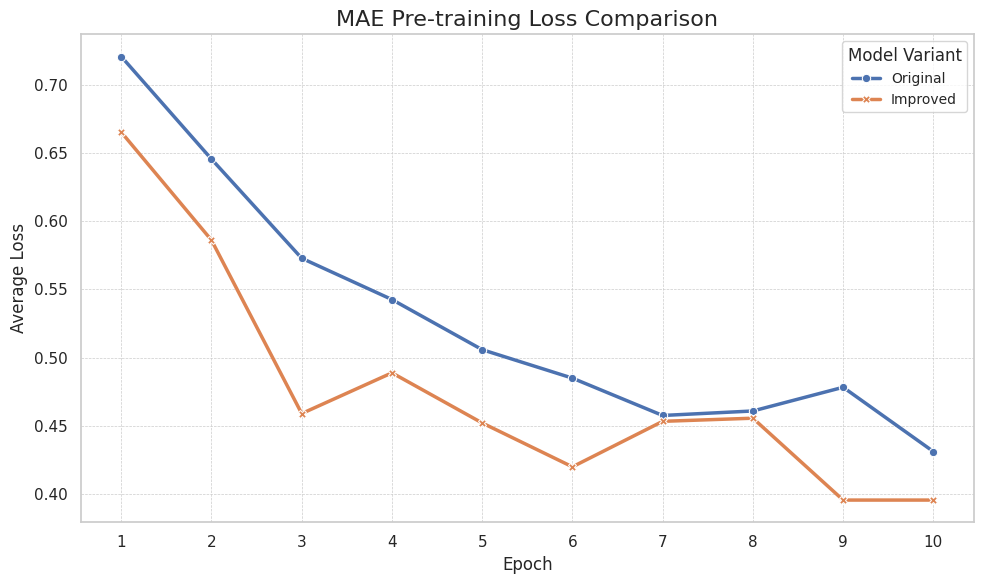

In [14]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Paste your raw log data here
log_data = """
Running Original MAE...
Pretrain Original E1/10: 100% 1563/1563 [03:53<00:00,  6.68it/s, lr=7.50e-05, mask=0.75, loss=0.7210]
Pretrain Original E2/10: 100% 1563/1563 [03:48<00:00,  6.84it/s, lr=1.50e-04, mask=0.75, loss=0.6457]
Pretrain Original E3/10: 100% 1563/1563 [03:51<00:00,  6.76it/s, lr=1.44e-04, mask=0.75, loss=0.5729]
Pretrain Original E4/10: 100% 1563/1563 [03:51<00:00,  6.75it/s, lr=1.28e-04, mask=0.75, loss=0.5426]
Pretrain Original E5/10: 100% 1563/1563 [03:46<00:00,  6.89it/s, lr=1.04e-04, mask=0.75, loss=0.5058]
Pretrain Original E6/10: 100% 1563/1563 [03:51<00:00,  6.74it/s, lr=7.50e-05, mask=0.75, loss=0.4849]
Pretrain Original E7/10: 100% 1563/1563 [03:46<00:00,  6.90it/s, lr=4.63e-05, mask=0.75, loss=0.4575]
Pretrain Original E8/10: 100% 1563/1563 [03:52<00:00,  6.73it/s, lr=2.20e-05, mask=0.75, loss=0.4608]
Pretrain Original E9/10: 100% 1563/1563 [03:48<00:00,  6.84it/s, lr=5.72e-06, mask=0.75, loss=0.4782]
Pretrain Original E10/10: 100% 1563/1563 [03:50<00:00,  6.78it/s, lr=2.37e-12, mask=0.75, loss=0.4310]
Running Improved MAE...
Pretrain Improved E1/10: 100% 1563/1563 [03:57<00:00,  6.58it/s, lr=7.50e-05, mask=0.55, loss=0.6655]
Pretrain Improved E2/10: 100% 1563/1563 [03:55<00:00,  6.62it/s, lr=1.50e-04, mask=0.60, loss=0.5862]
Pretrain Improved E3/10: 100% 1563/1563 [03:56<00:00,  6.62it/s, lr=1.44e-04, mask=0.65, loss=0.4589]
Pretrain Improved E4/10: 100% 1563/1563 [03:53<00:00,  6.69it/s, lr=1.28e-04, mask=0.70, loss=0.4888]
Pretrain Improved E5/10: 100% 1563/1563 [03:51<00:00,  6.76it/s, lr=1.04e-04, mask=0.75, loss=0.4520]
Pretrain Improved E6/10: 100% 1563/1563 [03:45<00:00,  6.93it/s, lr=7.50e-05, mask=0.75, loss=0.4198]
Pretrain Improved E7/10: 100% 1563/1563 [03:48<00:00,  6.84it/s, lr=4.63e-05, mask=0.75, loss=0.4532]
Pretrain Improved E8/10: 100% 1563/1563 [03:46<00:00,  6.91it/s, lr=2.20e-05, mask=0.75, loss=0.4555]
Pretrain Improved E9/10: 100% 1563/1563 [03:51<00:00,  6.74it/s, lr=5.72e-06, mask=0.75, loss=0.3954]
Pretrain Improved E10/10: 100% 1563/1563 [03:51<00:00,  6.74it/s, lr=5.72e-06, mask=0.75, loss=0.3954]
"""

# 2. Define a regex pattern to capture the important bits
# We're looking for:
# 1. (Original|Improved) - The model variant
# 2. E(\d+) - The epoch number
# 3. loss=([\d.]+) - The final loss value
pattern = re.compile(r"Pretrain (Original|Improved) E(\d+)/\d+: .*? loss=([\d\.]+)")

# 3. Parse the data
data = []
for line in log_data.strip().split('\n'):
    match = pattern.search(line)
    if match:
        model, epoch, loss = match.groups()
        data.append({
            'model': model,
            'epoch': int(epoch),
            'loss': float(loss)
        })

# 4. Create a DataFrame
df = pd.DataFrame(data)

print("Parsed Data:")
print(df.to_markdown(index=False))

# 5. Plot the data
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df,
    x='epoch',
    y='loss',
    hue='model',  # This automatically creates separate lines
    style='model', # Optional: adds different line styles
    markers=True,  # Adds markers to each data point
    dashes=False,
    linewidth=2.5
)

plt.title('MAE Pre-training Loss Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.legend(title='Model Variant', fontsize=10)
# Ensure x-axis ticks are integers for epochs
plt.xticks(ticks=df['epoch'].unique())
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import shutil, os
from google.colab import files

if os.path.isdir('runs'):
    shutil.make_archive('runs', 'zip', 'runs')
    files.download('runs.zip')

if os.path.isdir('data'):
    shutil.make_archive('data', 'zip', 'data')
    files.download('data.zip')

Saved comparison grid to: runs/compare/recon_grid.png
Masked PSNR: Original=17.697 dB | Improved=17.561 dB
Masked HF error (L1 on Laplacian): Original=0.03324 | Improved=0.03037


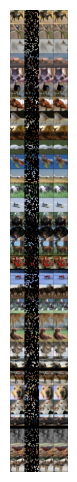

In [15]:
# Side-by-side reconstructions and quick metrics for Original vs Improved
import torch
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Reuse model + helper from mae_compare.py
from mae_compare import MAE, expand_patch_mask_to_image

device = "cuda" if torch.cuda.is_available() else "cpu"
img_size = 224
patch_size = 16
mask_ratio = 0.75
out_dir = Path("./runs/compare")
out_dir.mkdir(parents=True, exist_ok=True)

# Create two model instances (same arch as training)
def make_model():
    m = MAE(
        img_size=img_size,
        patch_size=patch_size,
        embed_dim=192,
        depth=8,
        num_heads=6,
        decoder_embed_dim=128,
        decoder_depth=4,
        decoder_num_heads=4,
        norm_pix_loss=True,
    ).to(device).eval()
    return m

m_orig = make_model()
m_impr = make_model()

def load_state(model, dirpath: str):
    p1 = Path(dirpath) / "encoder_pretrained.pt"
    p2 = Path(dirpath) / "checkpoint_last.pt"
    if p1.exists():
        sd = torch.load(p1, map_location="cpu")
        model.load_state_dict(sd)
        return True
    if p2.exists():
        chk = torch.load(p2, map_location="cpu")
        model.load_state_dict(chk["model"])
        return True
    return False

assert load_state(m_orig, "./runs/original"), "Could not load original model"
assert load_state(m_impr, "./runs/improved"), "Could not load improved model"

# Dataset (test split, no normalization)
vis_tf = transforms.Compose([
    transforms.Resize(int(img_size * 1.14)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),  # [0,1]
])
ds = tv.datasets.STL10(root="./data", split="test", download=True, transform=vis_tf)
dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Deterministic mask builder
def compute_mask_indices(B, L, mask_ratio, device, seed=1234):
    gen = torch.Generator(device=device); gen.manual_seed(seed)
    noise = torch.rand(B, L, device=device, generator=gen)
    ids_shuffle = torch.argsort(noise, dim=1)
    len_keep = int(L * (1 - mask_ratio))
    ids_keep = ids_shuffle[:, :len_keep]
    ids_restore = torch.argsort(ids_shuffle, dim=1)
    mask = torch.ones(B, L, device=device)
    mask[:, :len_keep] = 0
    mask = torch.gather(mask, dim=1, index=ids_restore)
    return ids_keep, ids_restore, mask

@torch.no_grad()
def encode_with_custom_mask(model: MAE, imgs: torch.Tensor, ids_keep: torch.Tensor):
    x = model.patch_embed(imgs) + model.pos_embed_enc
    B, L, C = x.shape
    x_vis = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, C))
    for blk in model.encoder:
        x_vis = blk(x_vis)
    x_vis = model.enc_norm(x_vis)
    return x_vis

@torch.no_grad()
def denorm_pred_with_target_stats(model: MAE, pred: torch.Tensor, imgs: torch.Tensor):
    target = model.patchify(imgs)
    mean = target.mean(dim=-1, keepdim=True)
    std = torch.sqrt(target.var(dim=-1, keepdim=True) + 1e-6)
    pred_denorm = pred * std + mean
    return model.unpatchify(pred_denorm).clamp(0, 1)

def psnr_masked(pred, tgt, mask_img, eps=1e-8):
    # pred,tgt: BxCxHxW in [0,1]; mask_img: Bx1xHxW (1=masked)
    mse = (((pred - tgt) ** 2) * mask_img).sum(dim=(1,2,3)) / (mask_img.sum(dim=(1,2,3)) + eps)
    psnr = -10.0 * torch.log10(mse + eps)
    return psnr.mean().item()

def lap_err_masked(pred, tgt, mask_img):
    # high-frequency error (same depthwise Laplacian used during improved training)
    B, C, H, W = pred.shape
    base = torch.tensor([[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]], device=pred.device).view(1,1,3,3)
    k = base.repeat(C,1,1,1)
    Lp = torch.nn.functional.conv2d(pred, k, padding=1, groups=C)
    Lt = torch.nn.functional.conv2d(tgt, k, padding=1, groups=C)
    diff = (Lp - Lt).abs() * mask_img
    denom = mask_img.sum() * C + 1e-6
    return (diff.sum() / denom).item()

tiles = []
L = (img_size // patch_size) ** 2
num_batches = 2  # 32 images; increase to show more
psnr_o_list, psnr_p_list = [], []
hf_o_list, hf_p_list = [], []

for bidx, (imgs, _) in enumerate(dl):
    if bidx >= num_batches:
        break
    imgs = imgs.to(device)
    B = imgs.size(0)
    ids_keep, ids_restore, mask = compute_mask_indices(B, L, mask_ratio, device)
    z_o = encode_with_custom_mask(m_orig, imgs, ids_keep)
    z_p = encode_with_custom_mask(m_impr, imgs, ids_keep)
    pred_o = m_orig.forward_decoder(z_o, ids_restore)
    pred_p = m_impr.forward_decoder(z_p, ids_restore)
    rec_o = denorm_pred_with_target_stats(m_orig, pred_o, imgs)
    rec_p = denorm_pred_with_target_stats(m_impr, pred_p, imgs)
    mask_img = expand_patch_mask_to_image(mask, img_size, patch_size)
    masked_in = imgs * (1.0 - mask_img)
    over_o = rec_o * mask_img + imgs * (1.0 - mask_img)
    over_p = rec_p * mask_img + imgs * (1.0 - mask_img)

    # metrics on masked area
    psnr_o_list.append(psnr_masked(rec_o, imgs, mask_img))
    psnr_p_list.append(psnr_masked(rec_p, imgs, mask_img))
    hf_o_list.append(lap_err_masked(rec_o, imgs, mask_img))
    hf_p_list.append(lap_err_masked(rec_p, imgs, mask_img))

    for i in range(B):
        tiles += [imgs[i].cpu(), masked_in[i].cpu(), over_o[i].cpu(), over_p[i].cpu()]

grid = make_grid(tiles, nrow=4, padding=2)
save_path = out_dir / "recon_grid.png"
save_image(grid, save_path)
print(f"Saved comparison grid to: {save_path}")

print(f"Masked PSNR: Original={np.mean(psnr_o_list):.3f} dB | Improved={np.mean(psnr_p_list):.3f} dB")
print(f"Masked HF error (L1 on Laplacian): Original={np.mean(hf_o_list):.5f} | Improved={np.mean(hf_p_list):.5f}")

plt.figure(figsize=(12, 3 * num_batches))
plt.axis("off")
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.show()